In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx
import math
from itertools import product
from itertools import combinations
from itertools import groupby
from collections import defaultdict
from collections import Counter
import warnings
import time
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

#local imports
import homocore as homoc

/home/machoi/higher-order-single-cell/source


In [2]:
reload(homoc)

/home/machoi/higher-order-single-cell/source


<module 'homocore' from '/home/machoi/higher-order-single-cell/notebooks/core/homocore.py'>

In [3]:
def generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes,
                                      edge_probability_core, edge_probability_periphery,
                                      avg_edge_size, core_periphery_probability):
    """
    This function generates a random hypergraph with a core-periphery structure and creates its binary incidence matrix.

    Args:
      num_core_nodes: Number of nodes in the core.
      num_periphery_nodes: Number of nodes in the periphery.
      edge_probability_core: Probability of an edge forming between core nodes.
      edge_probability_periphery: Probability of an edge forming between periphery nodes.
      avg_edge_size: Average number of nodes per edge.
      core_periphery_probability: Probability of an edge forming between a core node and a periphery node.

    Returns:
      A tuple containing four elements:
          * core_nodes: List of core nodes.
          * periphery_nodes: List of periphery nodes.
          * edges: List of edges.
          * incidence_matrix: Binary incidence matrix as a NumPy array.
    """
    import numpy as np

    # Define core and periphery nodes
    core_nodes = list(range(num_core_nodes))
    periphery_nodes = list(range(num_core_nodes, num_core_nodes + num_periphery_nodes))

    # Get total number of nodes
    total_nodes = len(core_nodes) + len(periphery_nodes)

    # Generate edges
    edges = []
    for _ in range(int(len(core_nodes) * edge_probability_core)):
        # Sample core nodes for an edge
        edge = random.sample(core_nodes, k=int(avg_edge_size))
        edges.append(edge)

    for _ in range(int(len(periphery_nodes) * edge_probability_periphery)):
        # Sample periphery nodes for an edge
        edge = random.sample(periphery_nodes, k=int(avg_edge_size))
        edges.append(edge)

    # Add edges between core and periphery nodes
    for _ in range(int(num_core_nodes * num_periphery_nodes * core_periphery_probability)):
        # Sample a core node and a periphery node
        core_node = random.choice(core_nodes)
        periphery_node = random.choice(periphery_nodes)
        # Create an edge with the core and periphery node
        edge = [core_node, periphery_node]
        # Optionally, you can sample additional nodes for the edge
        if avg_edge_size > 2:
            additional_nodes = random.sample(core_nodes + periphery_nodes, k=int(avg_edge_size) - 2)
            edge.extend(additional_nodes)
            
        edges.append(edge)

    # Create empty matrix
    incidence_matrix = np.zeros((total_nodes, len(edges)), dtype=int)

    # Fill the matrix with 1s for corresponding nodes in each edge
    for i, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node, i] = 1

    return core_nodes, periphery_nodes, edges, incidence_matrix

# Example usage
num_core_nodes = 3
num_periphery_nodes = 12
edge_probability_core = 0.9
edge_probability_periphery = 0.2
avg_edge_size = 3
core_periphery_probability = 0.1

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

print(type(incidence_matrix))
H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
H

<class 'numpy.ndarray'>
H.shape=(15, 7)


,0,1,2,3,4,5,6
0,1,1,0,0,0,0,0
1,1,1,0,0,0,0,1
2,1,1,0,0,1,1,0
3,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0
6,0,0,1,0,0,0,1
7,0,0,1,0,1,0,0
8,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0


# Plot the Hypergraphs

Text(0.5, 0, 'Hyperedges')

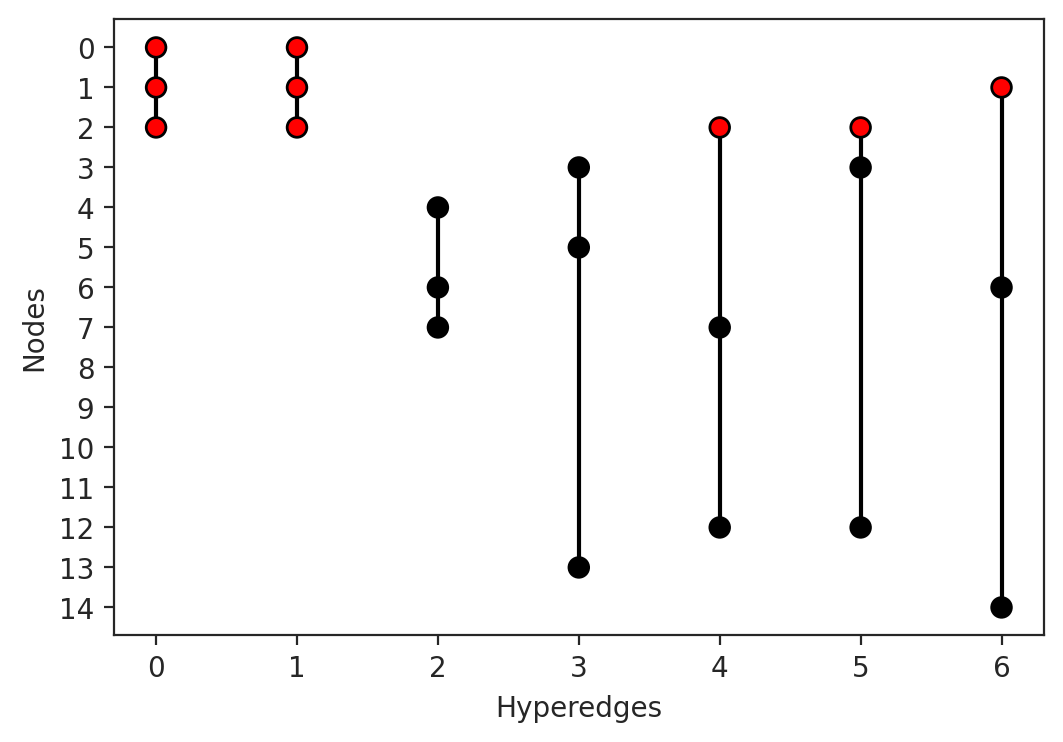

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

for i, column in enumerate(H.columns):
    hyperedge = H[column][H[column] > 0]
    order = len(hyperedge)
    x_ind = np.ones(order) * i
    
    c = np.where(hyperedge.index.isin(core_nodes), 'r', 'k')

    # Plot nodes
    plt.scatter(x_ind, 
                hyperedge.index, 
                s=50,
                c=c, 
                ec='k',
                zorder=3)

    # Plot edges
    plt.plot(x_ind, 
             hyperedge.index,
             c='k') 
    
plt.yticks(range(H.shape[0]))
plt.gca().invert_yaxis()
plt.ylabel('Nodes')
plt.xlabel('Hyperedges')

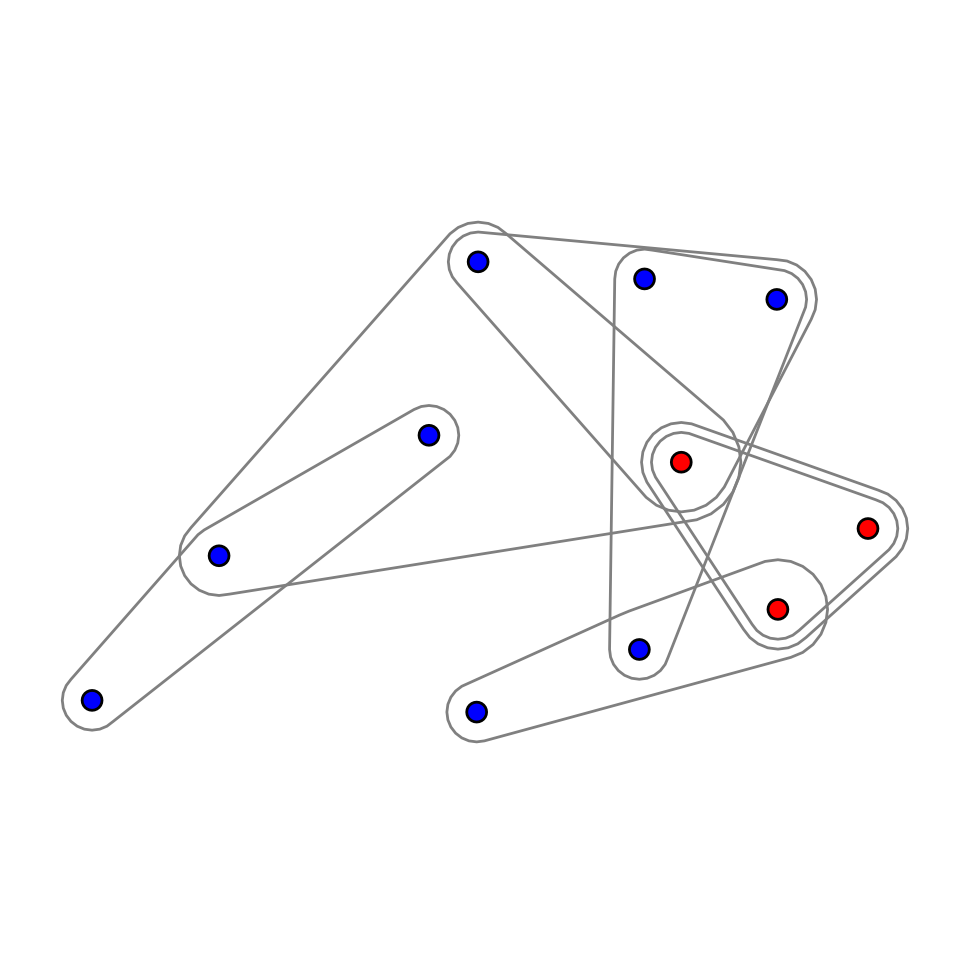

In [5]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx] = tuple(row[row == 1].index)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )
 

/home/machoi/higher-order-single-cell/source
{(1, 6, 10), (3, 5, 9), (2, 7, 8), (2, 3, 8), (0, 1, 2), (4, 6, 7)}
this is the OG graph:  {(1, 6, 10), (3, 5, 9), (2, 7, 8), (2, 3, 8), (0, 1, 2), (4, 6, 7)}
(1, 6, 10)
(3, 5, 9)
these are the possible maps:  [{3: 1, 5: 3, 9: 5}, {3: 1, 5: 3, 9: 6}, {3: 1, 5: 3, 9: 9}, {3: 1, 5: 3, 9: 10}, {3: 1, 5: 5, 9: 3}, {3: 1, 5: 5, 9: 6}, {3: 1, 5: 5, 9: 9}, {3: 1, 5: 5, 9: 10}, {3: 1, 5: 6, 9: 3}, {3: 1, 5: 6, 9: 5}, {3: 1, 5: 6, 9: 9}, {3: 1, 5: 6, 9: 10}, {3: 1, 5: 9, 9: 3}, {3: 1, 5: 9, 9: 5}, {3: 1, 5: 9, 9: 6}, {3: 1, 5: 9, 9: 10}, {3: 1, 5: 10, 9: 3}, {3: 1, 5: 10, 9: 5}, {3: 1, 5: 10, 9: 6}, {3: 1, 5: 10, 9: 9}, {3: 3, 5: 1, 9: 5}, {3: 3, 5: 1, 9: 6}, {3: 3, 5: 1, 9: 9}, {3: 3, 5: 1, 9: 10}, {3: 3, 5: 5, 9: 1}, {3: 3, 5: 5, 9: 6}, {3: 3, 5: 5, 9: 9}, {3: 3, 5: 5, 9: 10}, {3: 3, 5: 6, 9: 1}, {3: 3, 5: 6, 9: 5}, {3: 3, 5: 6, 9: 9}, {3: 3, 5: 6, 9: 10}, {3: 3, 5: 9, 9: 1}, {3: 3, 5: 9, 9: 5}, {3: 3, 5: 9, 9: 6}, {3: 3, 5: 9, 9: 10}, {3: 3, 5: 10

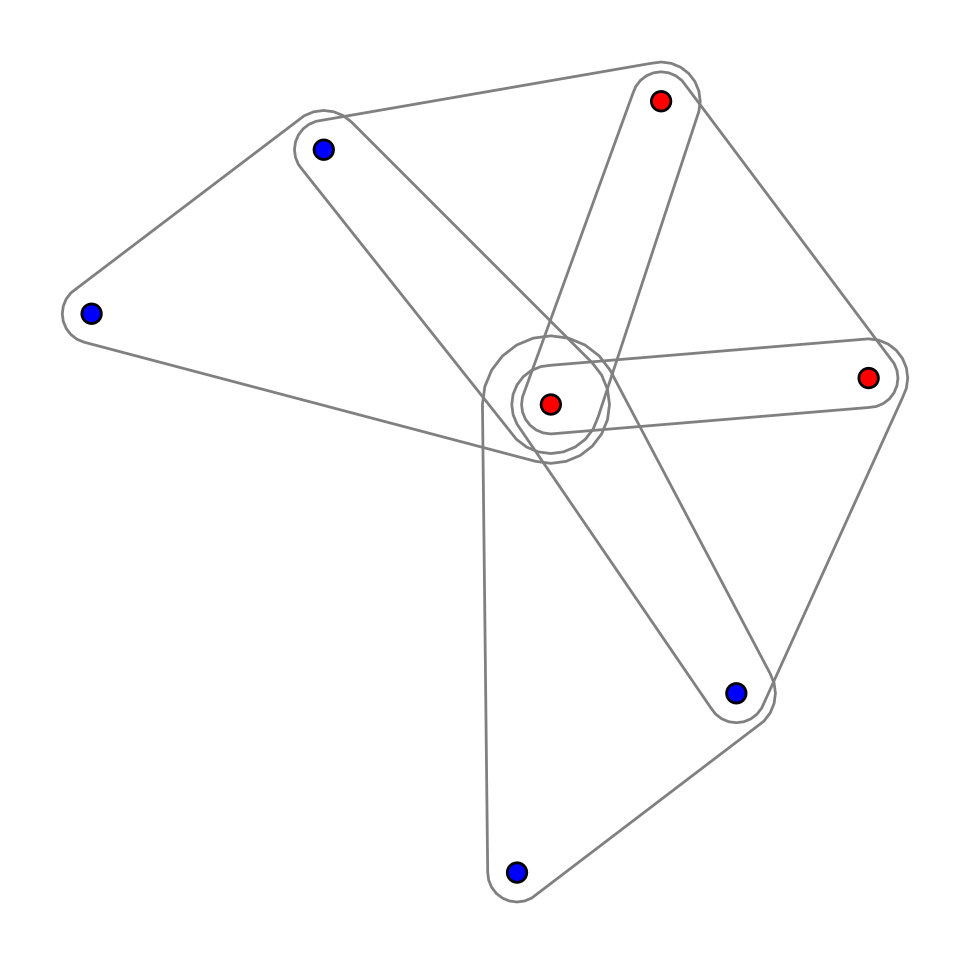

In [8]:
reload(homoc)
t = time.time()
'''
print(incidence_matrix)
num_cols = incidence_matrix.shape[1]

# Generate a random permutation of column indices
random_col_indices = np.random.permutation(num_cols)

# Reorder the columns using the random permutation
incidence_matrix = incidence_matrix[:, random_col_indices]
print(incidence_matrix)
'''
G = homoc.incidence_matrix_to_hyperedges(incidence_matrix)
G2 = homoc.reduce_tuples(G)
hx, meh = homoc.betterSolve(G2)
elapsed = time.time()-t
print(f'This is the time the alg took {elapsed}')
print(meh)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (6, 6)
hnx.drawing.draw(hx, with_node_counts=False, with_edge_counts=False, with_edge_labels=False, with_node_labels=False, nodes_kwargs={'color': node_color, 'edgecolor': 'k'}, edges_kwargs={'edgecolors': 'grey'}, layout_kwargs={'seed': 39})


{3: 0, 4: 1}


In [6]:
from itertools import product

def max_integer_in_tuples(tuples_set):
    # Flatten the set of tuples into a single iterable
    flattened_list = [item for tpl in tuples_set for item in tpl]
    
    # Return the maximum value from the flattened list
    return max(flattened_list)

'''
def verify(G, H, f):
#Verifies a possible graph homomorphism f from G to H
   homomorphism = True
   for edge in G:
       if not ((f[edge[0]], f[edge[1]]) in H or (f[edge[1]], f[edge[0]]) in H ):
           homomorphism = False
           break
   return homomorphism
'''

def verify_hypergraph(G, H, f):
    """
    Verifies if a possible hypergraph homomorphism f from hypergraph G to hypergraph H is valid.

    Parameters:
    - G: Set of hyperedges in the source hypergraph G (where each hyperedge is a tuple of vertices)
    - H: Set of hyperedges in the target hypergraph H (where each hyperedge is a tuple of vertices)
    - f: Function representing the homomorphism, mapping vertices in G to vertices in H

    Returns:
    - True if f is a valid hypergraph homomorphism from G to H, False otherwise
    """
    for hyperedge in G:
        # Map the vertices of the hyperedge under the homomorphism
        mapped_hyperedge = tuple(sorted(f[v] for v in hyperedge))
        # Check if the mapped hyperedge exists in the target hypergraph H
        if mapped_hyperedge not in H:
            return False
    return True
'''
def solve(G, H):
#Finds the number of homomorphisms from graph G to graph H and the smallest one
   m = max_integer_in_tuples(G)+1
   n = max_integer_in_tuples(H)+1
   rangeG = [i for i in range(n)]
   assignments = generate_all_tuples(n, m)
   cnt = 0
   possible_assignments = []
   for f in assignments:
       if verify_hypergraph(G, H, f):
           cnt += 1
           possible_assignments.append(f)
   if cnt > 0:
       print(f'Number of homomorphisms {cnt}')
       best = smallest_homomorphism(possible_assignments)
       print(f'The best homomorphism is given by {best}')
       new_set = recover_edges(best, H)
       df_imatrix = create_incidence_matrix_dataframe(new_set)
       print(df_imatrix)
       hx = to_hypernet(df_imatrix)
       plt.rcParams['figure.dpi'] = 200
       plt.rcParams['figure.figsize'] = 6, 6
       hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )
   else:
       print('No core exists')
   return cnt
'''

def solve(G):
    # Step 1: Determine the size parameters for the tuples
    n = max_integer_in_tuples(G) + 1

    # Step 2: Generate all possible assignments
    
    t = time.time()
    #assignments = generate_all_tuples(n, m)
    #k = max(len(tpl) for tpl in G)
    #assignments = generate_tuples_with_k_different(n, k)
    assignments = generate_all_tuples(n,n)
    elapsed = time.time() - t
    print(f'Generation Complete: {elapsed} seconds')

    # Step 3: Verify each assignment and collect valid homomorphisms
    t = time.time()
    homomorphism_size = math.inf
    possible_assignments = []
    for f in assignments:
        poss_size = len(set(f))
        if poss_size < homomorphism_size:
            if verify_hypergraph(G,G,f):
                possible_assignments.append(f)
                homomorphism_size = poss_size
    cnt = len(possible_assignments)
    elapsed = time.time() - t
    print(f'Homomorphism Validation Complete: {elapsed} seconds')

    if cnt > 0:
        # Step 4: Find the smallest homomorphism
        t = time.time()
        best = smallest_homomorphism(possible_assignments)
        print(f'Number of homomorphisms: {cnt}')
        print(f'The best homomorphism is given by {best}')
        elapsed = time.time() - t
        print(f'Smallest Homomorphism Found: {elapsed} seconds')

        # Step 5: Process the best homomorphism
        t = time.time()
        new_set = recover_edges(best, G)
        df_imatrix = create_incidence_matrix_dataframe(new_set)
        elapsed = time.time() - t
        print(f'Core Found: {elapsed} seconds')

        # Step 6: Visualize the result
        t = time.time()
        hx = to_hypernet(df_imatrix)
        plt.rcParams['figure.dpi'] = 200
        plt.rcParams['figure.figsize'] = (6, 6)
        hnx.drawing.draw(hx, 
                         with_node_counts=False, 
                         with_edge_counts=False,
                         with_edge_labels=False, 
                         with_node_labels=False,
                         nodes_kwargs={'color': node_color, 'edgecolor': 'k'},
                         edges_kwargs={'edgecolors': 'grey'},
                         layout_kwargs={'seed': 39})
        elapsed = time.time() - t
        print(f'Visualization Complete: {elapsed} seconds')
    else:
        print('No core exists')

    return cnt
    
def generate_all_tuples(n, m):
    # Create a range of numbers from 1 to n (or any other set of n distinct numbers)
    numbers = range(0, n)
    
    # Generate all possible tuples of size m with elements from the numbers range
    all_tuples = list(product(numbers, repeat=m))
    
    return all_tuples

def generate_half_tuples(n):
    """
    Generate a list of tuples of n integers where each integer at index i
    cannot be larger than i.

    Parameters:
    - n: The length of the tuples

    Returns:
    - A list of tuples meeting the criteria
    """
    # Create a list of ranges for each index
    ranges = [range(i + 1) for i in range(n)]
    
    # Generate all possible tuples with constraints
    tuples_list = list(product(*ranges))
    
    return tuples_list

def smallest_homomorphism(possible):
    # Initialize with the worst possible size (infinity)
    smallest_size = math.inf
    best_homomorphism = None
    
    for assignment in possible:
        candidate_size = len(set(assignment))
        
        # Update if the current candidate is smaller
        if candidate_size < smallest_size:
            smallest_size = candidate_size
            best_homomorphism = assignment
            
    return best_homomorphism

def get_combinations_as_tuples(tuples_set, combination_size):
    # Convert the set to a list to use combinations
    tuples_list = list(tuples_set)
    
    # Generate all possible combinations of the specified size
    all_combinations = combinations(tuples_list, combination_size)
    
    # Convert each combination to a tuple and return as a list of tuples
    return set([tuple(comb) for comb in all_combinations])

def recover_edges(result, original_edges):
    # Convert original_edges to a set for faster lookup
    original_edges_set = set(map(tuple, map(sorted, original_edges)))
    
    compression = set(result)
    largest_edge_size = max(map(len, original_edges), default=0)
    
    # Generate all combinations of the desired size
    all_combinations = get_combinations_as_tuples(compression, largest_edge_size)
    
    # Convert all combinations to a set of sorted tuples for efficient lookup
    real_combinations = {tuple(sorted(tpl)) for tpl in all_combinations}
    
    # Use list comprehension for more concise and potentially faster execution
    new_edge_list = [comb for comb in real_combinations if comb in original_edges_set]
    
    return new_edge_list
    
'''
def recover_edges(result, original_edges):
    compression = set(result)
    largest_edge_size = max(map(len, original_edges), default=0)
    all_combinations = get_combinations_as_tuples(compression, largest_edge_size)
    print(all_combinations)
    real_combinations = {tuple(sorted(tpl)) for tpl in all_combinations}
    new_edge_list = []
    for comb in real_combinations:
        if comb in original_edges:
            print(f'combination found: {comb}')
            new_edge_list.append(comb)
    return new_edge_list
'''
    
def create_graph(edge_set):
    G = nx.Graph()
    G.add_edges_from(edge_set)
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
    plt.show()

def incidence_matrix_to_hyperedges(matrix):
    # Convert the incidence matrix to a numpy array for easier manipulation
    #matrix = np.array(incidence_matrix)
    row_sums = np.sum(matrix, axis=1)
    
    # Get the indices that would sort the row sums in descending order
    sorted_indices = np.argsort(row_sums)[::-1]
    
    # Reorder rows according to the sorted indices
    reordered_matrix = matrix[sorted_indices]
    print(reordered_matrix)
    # List to hold the hyperedges as tuples of vertices
    hyperedges = set()
    
    # Number of vertices and hyperedges
    num_vertices, num_hyperedges = reordered_matrix.shape
    
    # Loop through each hyperedge (column)
    for hyperedge_index in range(num_hyperedges):
        # Find vertices incident to this hyperedge
        vertices = np.where(matrix[:, hyperedge_index] == 1)[0]
        
        # Create a sorted tuple of vertices for the hyperedge
        if len(vertices) > 0:
            hyperedge = tuple(sorted(vertices))
            hyperedges.add(hyperedge)
    
    return hyperedges


def reduce_tuples(tuples_set):
    # Step 1: Extract all unique numbers
    unique_numbers = set()
    for tpl in tuples_set:
        unique_numbers.update(tpl)
    
    # Step 2: Create a mapping from original numbers to smallest integers
    sorted_numbers = sorted(unique_numbers)
    number_mapping = {num: idx for idx, num in enumerate(sorted_numbers)}
    
    # Step 3: Apply the mapping to each tuple
    reduced_tuples = {tuple(number_mapping[num] for num in tpl) for tpl in tuples_set}
    
    return reduced_tuples


def create_incidence_matrix_dataframe(hyperedges):
    # Step 1: Extract all unique vertices and hyperedges
    unique_vertices = sorted(set(v for hyperedge in hyperedges for v in hyperedge))
    unique_hyperedges = sorted(hyperedges)
    
    # Create a mapping from vertices to rows
    vertex_index = {v: i for i, v in enumerate(unique_vertices)}
    
    # Create a mapping from hyperedges to columns
    hyperedge_index = {he: j for j, he in enumerate(unique_hyperedges)}
    
    # Initialize the incidence matrix
    incidence_matrix = np.zeros((len(unique_vertices), len(unique_hyperedges)), dtype=int)
    
    # Fill the incidence matrix
    for hyperedge in unique_hyperedges:
        col = hyperedge_index[hyperedge]
        for vertex in hyperedge:
            row = vertex_index[vertex]
            incidence_matrix[row, col] = 1
    
    # Create a DataFrame from the incidence matrix
    df = pd.DataFrame(incidence_matrix, index=unique_vertices, columns=[str(he) for he in unique_hyperedges])
    
    return df


def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx] = tuple(row[row == 1].index)

    hx = hnx.Hypergraph(iteractions)
    return hx
    


def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'


def generate_tuples_with_k_different(n, k):
    """
    Generate a list of tuples of n integers where:
    - Each integer at index i cannot be larger than i.
    - There must be at least k different integers in each tuple.

    Parameters:
    - n: The size of each tuple
    - k: The minimum number of different integers required in each tuple

    Returns:
    - A list of valid tuples
    """
    # Create a list of ranges for each index
    ranges = [range(i + 1) for i in range(n)]
    
    # Generate all possible tuples with the given ranges
    all_tuples = product(*ranges)
    
    # Filter tuples based on the distinct integers condition
    valid_tuples = [
        tpl for tpl in all_tuples
        if len(set(tpl)) >= k
    ]
    
    return valid_tuples


[[1 1 0 0 1]
 [1 1 0 1 0]
 [0 0 1 1 0]
 [1 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
{(0, 1, 2), (1, 7, 8), (3, 4, 8), (2, 5, 6)}
[(0, 1, 2), (1, 7, 8), (3, 4, 8), (2, 5, 6)]
[(0, 1, 2), (2, 5, 6), (3, 4, 8), (1, 7, 8)]
{(0, 1, 2)}
{(0, 1, 2)}
These are the possible maps [{5: 0, 6: 1}, {5: 0, 6: 2}, {5: 1, 6: 0}, {5: 1, 6: 2}, {5: 2, 6: 0}, {5: 2, 6: 1}]
{(0, 1, 2), (2, 5, 6)}
These are the possible maps [{3: 0, 4: 1, 8: 2}, {3: 0, 4: 2, 8: 1}, {3: 1, 4: 0, 8: 2}, {3: 1, 4: 2, 8: 0}, {3: 2, 4: 0, 8: 1}, {3: 2, 4: 1, 8: 0}]
{(0, 1, 2), (3, 4, 8), (2, 5, 6)}
These are the possible maps [{7: 0}, {7: 1}, {7: 2}]
This is how many nodes are in the core 3
This is the final map {0: 0, 1: 1, 2: 2, 5: 0, 6: 1, 3: 0, 4: 1, 8: 2, 7: 0}
Core Found: 0.0003829002380371094 seconds


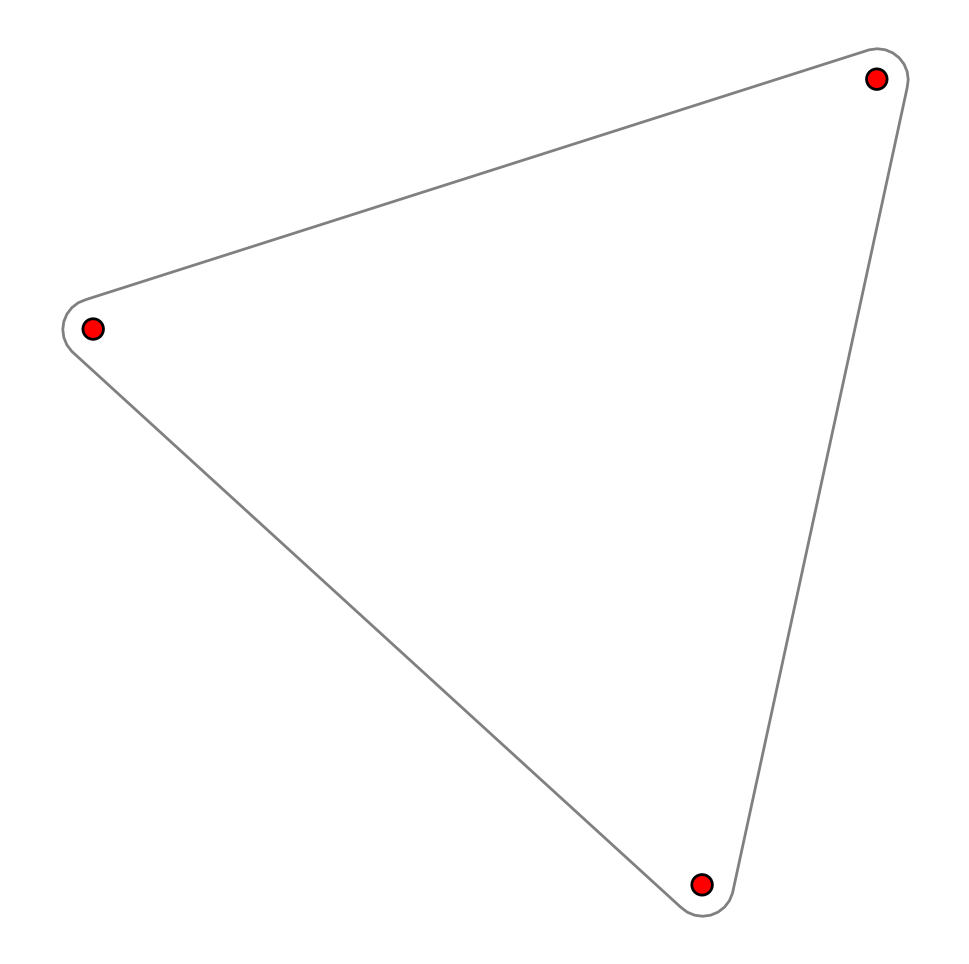

In [27]:
G = incidence_matrix_to_hyperedges(incidence_matrix)
G2 = reduce_tuples(G)
betterSolve(G2)

In [89]:
t3 = time.time()
test = {(0,1,2), (2,3), (0,1,3)}
G = incidence_matrix_to_hyperedges(incidence_matrix)
#print(G)
G2 = reduce_tuples(G)
#print(G2)
solve(G2)
elapsed3 = time.time() - t3
print(f'Search took {elapsed3} seconds')

[[1 1 0 0 1 0 1]
 [0 0 1 0 0 1 1]
 [1 1 0 0 0 1 0]
 [0 0 1 0 1 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Generation Complete: 47.627718687057495 seconds


KeyboardInterrupt: 

In [ ]:
break

# Graph Homomorphisms

full graph: {(0, 1, 2), (0, 1, 3), (2, 3)}
the edge we care about: (0, 1, 2)
final graph {(0, 1, 2), (0, 1, 3), (2, 3)}
the edge we care about: (0, 1, 3)
This is the missing key [3]
[(3, 0), (3, 1), (3, 2)]
This is the full potential mapping {0: 0, 1: 1, 2: 2, 3: 0}
pre mapped edges {(0, 1, 2), (0, 1, 3), (2, 3)}, with lengths [3, 3, 2]
post mapped edges [(0, 1, 2), (0, 0, 1), (0, 2)], with lengths [3, 2, 2]
This is the full potential mapping {0: 0, 1: 1, 2: 2, 3: 1}
pre mapped edges {(0, 1, 2), (0, 1, 3), (2, 3)}, with lengths [3, 3, 2]
post mapped edges [(0, 1, 2), (0, 1, 1), (1, 2)], with lengths [3, 2, 2]
This is the full potential mapping {0: 0, 1: 1, 2: 2, 3: 2}
pre mapped edges {(0, 1, 2), (0, 1, 3), (2, 3)}, with lengths [3, 3, 2]
post mapped edges [(0, 1, 2), (0, 1, 2), (2, 2)], with lengths [3, 3, 1]
final graph {(0, 1, 2), (0, 1, 3), (2, 3)}
the edge we care about: (2, 3)
final graph {(0, 1, 2), (0, 1, 3), (2, 3)}
This is how many nodes are in the core 4
This is the final ma

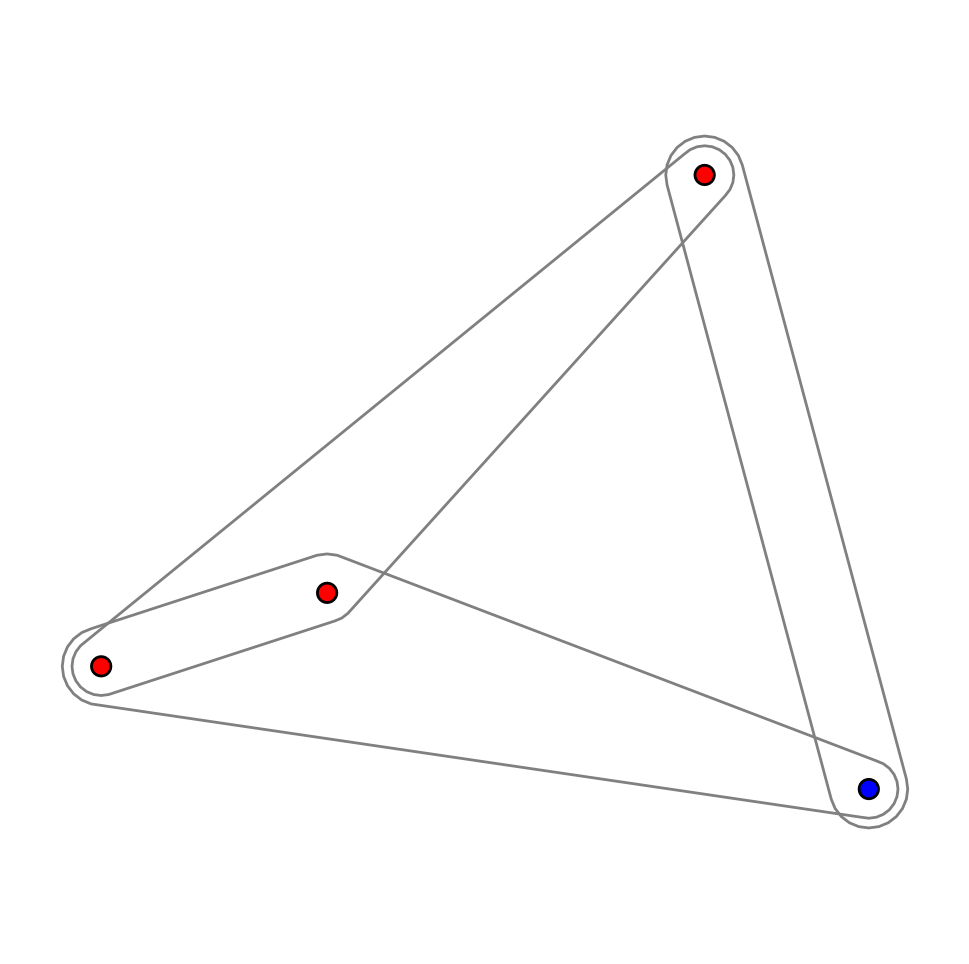

In [39]:
G = {(0,1,2), (2,3), (0,1,3)}

t = time.time()
betterSolve(G)
elapse = time.time()-t
print(f'Time is took is {elapse}')

In [26]:


#Runtime O(n*k)
def find_all_mappings(dictionary, integer_list):
    # List comprehension to generate all possible mappings
    dict_values = list(dictionary.values())
    possible_swaps = [(integer, element) for integer in integer_list for element in dict_values]
    return possible_swaps

#Runtime O(n)
def map_tuple_to_tuple(original_tuple, mapping_dict):
    # Apply the mapping dictionary to transform the tuple
    mapped_tuple = tuple(mapping_dict.get(item, item) for item in original_tuple)
    return mapped_tuple




def split_tuples_by_first_element(mappings):
    grouped = dict()
    for key, value in mappings:
        grouped[key] = value
    return grouped

def generate_dicts_from_combinations(groups):
    # Process each group efficiently
    return [{k: v for v in values} for k, values in groups.items()]



def generate_distinct_mappings(pairs):
    from itertools import combinations
    
    # Step 1: Group tuples by their first entry
    mappings = {}
    all_values = set()
    for key, value in pairs:
        if key not in mappings:
            mappings[key] = []
        mappings[key].append(value)
        all_values.add(value)
    
    # Step 2: Generate a list of keys and corresponding values
    keys = list(mappings.keys())
    values = list(all_values)
    
    # Step 3: Backtracking function to generate valid mappings
    def backtrack(current_mapping, remaining_keys, available_values):
        if not remaining_keys:
            valid_mappings.append(current_mapping.copy())
            return
        
        key = remaining_keys[0]
        for value in available_values:
            if value not in current_mapping.values() and value in mappings[key]:
                current_mapping[key] = value
                next_remaining_keys = remaining_keys[1:]
                backtrack(current_mapping, next_remaining_keys, available_values)
                del current_mapping[key]  # Undo the choice
    
    valid_mappings = []
    backtrack({}, keys, values)
    
    return valid_mappings
    

def edge_core_alg(G):
    print(G)
    temptemp = list(G)
    print(temptemp)
    G = sorted(temptemp, key=sum)
    print(G)
    #Put the first edge in the core (requires preprocessing to ensure the first edge should indeed be in the core (biggest edge?))
    iterator = iter(G)
    C = next(iterator)
    mapping_dictionary = {x: x for x in C}
    C = {C}
    #print(f'Initial core: {C}')
    #For each edge in the graph, try to map any nodes not included in the mapping to the original graph
    for e in G:
        print(C)
        #Add the edge into the core
        new_e = map_tuple_to_tuple(e, mapping_dictionary)
        C.add(new_e)
        break_condition = False
        #Find all the nodes of the core
        keys_set = set(mapping_dictionary.values())
        #Find all the nodes in the edge that is not in the core
        missing_keys = [x for x in new_e if x not in keys_set]
        if missing_keys:
            
            #Find all possible simultaneous mappings
            possible_maps = generate_distinct_mappings(find_all_mappings(mapping_dictionary, missing_keys))
            print(f'These are the possible maps {possible_maps}')
            #For each map
            for map in possible_maps:
                #create the true mapping
                combined_mapping = {**mapping_dictionary, **map}
                test_graph = [tuple(sorted(map_tuple_to_tuple(test_edges, combined_mapping))) for test_edges in G]
                edge_lengths = [len(set(tpl)) for tpl in G]
                post_edge_lengths = [len(set(tpl)) for tpl in test_graph]
                if edge_lengths == post_edge_lengths:
                    mapping_dictionary = combined_mapping
                    break_condition = True
                    break
        if break_condition == False:
            append_dictionary = {x: x for x in missing_keys}
            mapping_dictionary = {**mapping_dictionary, **append_dictionary}
            G = set(map_tuple_to_tuple(test_edges, mapping_dictionary) for test_edges in G)
    print(f'This is how many nodes are in the core {len(set(mapping_dictionary.values()))}')
    print(f'This is the final map {mapping_dictionary}')
    return mapping_dictionary


def betterSolve(G):
    t = time.time()
    map = edge_core_alg(G)
    new_set = set(tuple(sorted(map_tuple_to_tuple(e, map))) for e in G)
    df_imatrix = create_incidence_matrix_dataframe(new_set)
    elapsed = time.time() - t
    print(f'Core Found: {elapsed} seconds')
    hx = to_hypernet(df_imatrix)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (6, 6)
    hnx.drawing.draw(hx, 
                     with_node_counts=False, 
                     with_edge_counts=False,
                     with_edge_labels=False, 
                     with_node_labels=False,
                     nodes_kwargs={'color': node_color, 'edgecolor': 'k'},
                     edges_kwargs={'edgecolors': 'grey'},
                     layout_kwargs={'seed': 39})

[[1 0 1 0 0 1 1 0 0]
 [1 1 1 0 0 0 0 1 0]
 [1 1 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 0 1]
 [0 0 0 0 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 1]
 [0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
{(5, 6, 9), (1, 4, 7), (3, 5, 6), (1, 2, 3), (0, 2, 3), (4, 6, 8), (0, 2, 5)}
[(5, 6, 9), (1, 4, 7), (3, 5, 6), (1, 2, 3), (0, 2, 3), (4, 6, 8), (0, 2, 5)]
[(0, 2, 3), (1, 2, 3), (0, 2, 5), (1, 4, 7), (3, 5, 6), (4, 6, 8), (5, 6, 9)]
{(0, 2, 3)}
{(0, 2, 3)}
{1: 0}
We mapped the graph using the hypothetical function [(5, 6, 9), (0, 4, 7), (3, 5, 6), (0, 2, 3), (0, 2, 3), (4, 6, 8), (0, 2, 5)]
OG graph {(5, 6, 9), (1, 4, 7), (3, 5, 6), (1, 2, 3), (0, 2, 3), (4, 6, 8), (0, 2, 5)}
{(1, 2, 3), (0, 2, 3)}
{5: 0}
We mapped the graph using the hypothetical function [(0, 6, 9), (0, 4, 7), (0, 3, 6), (0, 2, 3), (0, 2, 3), (4, 6, 8), (0, 0, 2)]
OG graph {(5, 6, 9), (1, 4, 7), (3, 5, 6), (1, 2, 3), (0, 2, 3)

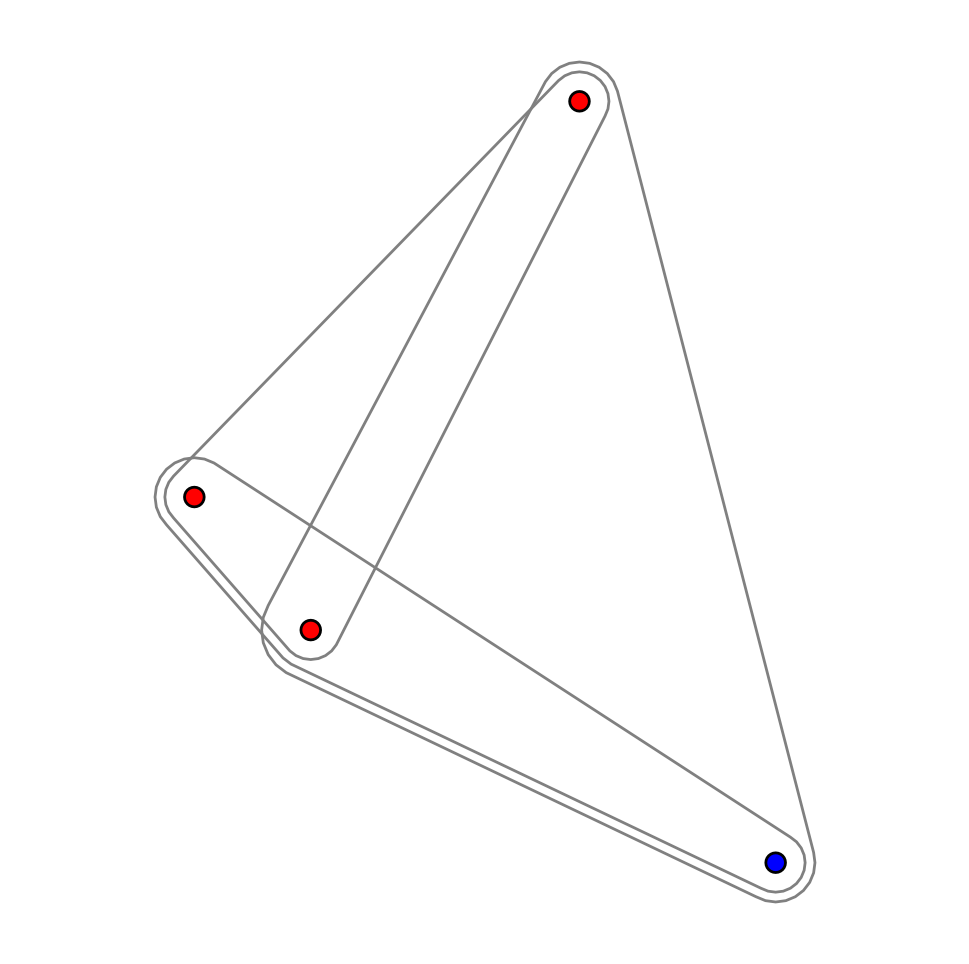

In [14]:
G = incidence_matrix_to_hyperedges(incidence_matrix)
G2 = reduce_tuples(G)
betterSolve(G2)

In [32]:
from itertools import product

def generate_mappings(core_nodes, extra_nodes):
    """
    Generates all possible mappings between core nodes and extra nodes where
    each core node maps to one of the extra nodes, and extra nodes can be used
    multiple times.

    Args:
        core_nodes (list): A list of core nodes.
        extra_nodes (list): A list of extra nodes.

    Returns:
        list: A list of valid mappings where each mapping is a dictionary.
    """
    # Generate all possible mappings using Cartesian product
    all_mappings = []
    for combination in product(core_nodes, repeat=len(extra_nodes)):
        mapping = dict(zip(core_nodes, combination))
        all_mappings.append(mapping)
    
    return all_mappings

# Example usage
core_nodes = [0, 1]
extra_nodes = [2, 3]

mappings = generate_mappings(core_nodes, extra_nodes)
for mapping in mappings:
    print(mapping)


{0: 0, 1: 0}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 1}


In [ ]:
G = {(0,1,2), (0,1,3), (2,3)}
betterSolve(G)

In [ ]:
# Example usage
hyperedges = {(0, 1, 2), (2, 3, 4), (4, 5)}
df_incidence_matrix = create_incidence_matrix_dataframe(hyperedges)
print(df_incidence_matrix)


In [21]:
def apply_count_unique_numbers_to_set_of_tuples(set_of_tuples):
    # Apply count_unique_numbers to each tuple in the set
    result = {len(set(tpl)) for tpl in set_of_tuples}
    return result

# Example usage
set_of_tuples = {(1, 2, 3), (2, 2, 3), (4, 5, 6, 7, 8), (5, 5, 5, 5)}
unique_counts = apply_count_unique_numbers_to_set_of_tuples(set_of_tuples)

print(f"Unique counts: {unique_counts}")

Unique counts: {1, 2, 3, 5}


In [ ]:
result = (3, 2, 3, 2)
H = {(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)}
edge_set = recover_edges(result, H)

create_graph(edge_set)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define a set of tuples representing edges
edges = {(0, 1), (1, 2), (2, 3), (3, 4), (4,0)}
edges2 = {(0,1),(1,2),(2,0)}
# Create an empty graph
G = nx.Graph()
G2 = nx.Graph()
# Add edges to the graph
G.add_edges_from(edges)
G2.add_edges_from(edges2)
# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
nx.draw(G2, with_labels=True, node_color='red', edge_color='gray', node_size=500, font_size=16)
plt.show()


In [ ]:
solve(edges, edges2)

In [ ]:
G = {(0, 1), (1, 0), (0, 2), (2, 0), (0, 3), (3, 0)}
H = {(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)}
solve(G,G)

In [ ]:
#K3
edges = {(0,1), (0,3), (0,5), (2,1), (2,3), (2,5), (4,1), (4,3), (4,5)}

# Create an empty graph
G = nx.Graph()
# Add edges to the graph
G.add_edges_from(edges)
# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
plt.show()

solve(edges,edges)

# Hypergraph Homomorphisms

In [ ]:
import numpy as np



# Example usage
incidence_matrix = [
    [1, 1, 0],
    [1, 0, 1],
    [0, 0, 0],
    [0, 1, 1]
]
incidence_matrix = np.array(incidence_matrix)

hyperedges_set = incidence_matrix_to_hyperedges(incidence_matrix)
print(hyperedges_set) 
solve(hyperedges_set, hyperedges_set)


# Compute nonlinear node centrality

In [ ]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)

colors = plt2.floats_to_colors(ncent, colormap='Reds')


def node_color(v):
    return colors[v, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'ec' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
break

In [ ]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)

colors = plt2.floats_to_colors(ecent, colormap='Reds')

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

def edge_color(v):
    return colors[v, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'ec' : 'k'},
                 edges_kwargs={'edgecolors': edge_color},
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
n_bins = 10
print(f"{H.shape=}")

res = []

for n_t in np.linspace(0, 1, n_bins):
    for e_t in np.linspace(0, 1, n_bins):
        node_idx = np.argwhere(ncent > n_t).ravel()
        edge_idx = np.argwhere(ecent > e_t).ravel()
        
        core = H.iloc[node_idx][edge_idx]
        # Check for empty core
        if core.empty:
            continue  # Skip this iteration if the core is empty
            
        nn, mm = core.shape

        # Minimum core size check
        if (nn > 2) & (mm > 2):
            L = matrix.hypergraph_laplacian(core)
            Lnorm = matrix.normalized_hypergraph_laplacian(core)

            # metrics
            fiedler_number = matrix.estimate_fiedler(Lnorm)
            entropy = matrix.hypergraph_entropy(L)
        else:
            fiedler_number = 0

        row = {
            'node_threshold': n_t,
            'edge_threshold': e_t,
            'n_nodes': nn,
            'n_edges': mm,
            'fiedler_number': fiedler_number,
            'entropy' : entropy,
        }
        res.append(row)
            
res = pd.DataFrame(res)
res.head()


In [ ]:
?hnx.drawing.draw

In [ ]:
def plot_core_periphery_networkx(core_nodes, periphery_nodes, edges):
    """
    This function plots a core-periphery network using NetworkX for layout and Matplotlib for visualization.

    Args:
      core_nodes: List of core nodes.
      periphery_nodes: List of periphery nodes.
      edges: List of lists, where each inner list represents an edge in the hypergraph.
    """
    plt.figure(figsize=(8, 6))

    # Create a NetworkX graph
    G = nx.Graph()

    # Add nodes with color distinction for core and periphery
    G.add_nodes_from(core_nodes, color='red')
    G.add_nodes_from(periphery_nodes, color='blue')

    # Add edges
    for edge in edges:
        for i in range(len(edge) - 1):
            G.add_edge(edge[i], edge[i + 1])

    # Use a layout algorithm for node positioning (adjust as needed)
    pos = nx.spring_layout(G)

    # Draw the graph with node colors and positions
    nx.draw_networkx_nodes(G, pos, nodelist=periphery_nodes, node_color='blue', node_size=150, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='red', node_size=350, edgecolors='k')
    nx.draw_networkx_edges(G, pos, alpha=0.7, width=1.5)

    # Labels and title
    plt.axis('off')
    plt.show()
    
plt.rcParams['figure.dpi'] = 200
plot_core_periphery_networkx(core_nodes, periphery_nodes, edges)

In [ ]:
break